In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D,BatchNormalization
from keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam


In [2]:
# Load the flowers dataset
(train_ds, val_ds), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
num_classes = dataset_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of classes: 5


In [4]:
# Preprocess and augment data
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    # Random left-right flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (0, 90, 180, or 270 degrees)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label


In [5]:
# Set up the data pipelines
train_ds = (train_ds
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

val_ds = (val_ds
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

In [6]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(num_classes, activation='sigmoid'))

In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

In [9]:
# Train the model
EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/15
92/92 [==============================] - 29s 289ms/step - loss: 1.4773 - accuracy: 0.3311 - val_loss: 1.3608 - val_accuracy: 0.3842
Epoch 2/15
92/92 [==============================] - 24s 258ms/step - loss: 1.2732 - accuracy: 0.4445 - val_loss: 1.1682 - val_accuracy: 0.5082
Epoch 3/15
92/92 [==============================] - 24s 259ms/step - loss: 1.2066 - accuracy: 0.4850 - val_loss: 1.1211 - val_accuracy: 0.4905
Epoch 4/15
92/92 [==============================] - 24s 255ms/step - loss: 1.0841 - accuracy: 0.5378 - val_loss: 1.0617 - val_accuracy: 0.5232
Epoch 5/15
92/92 [==============================] - 24s 257ms/step - loss: 1.0330 - accuracy: 0.5719 - val_loss: 1.1823 - val_accuracy: 0.5204
Epoch 6/15
92/92 [==============================] - 23s 254ms/step - loss: 1.0023 - accuracy: 0.5821 - val_loss: 0.9619 - val_accuracy: 0.5613
Epoch 7/15
92/92 [==============================] - 24s 256ms/step - loss: 0.9374 - accuracy: 0.6175 - val_loss: 0.9131 - val_accuracy: 0.6185

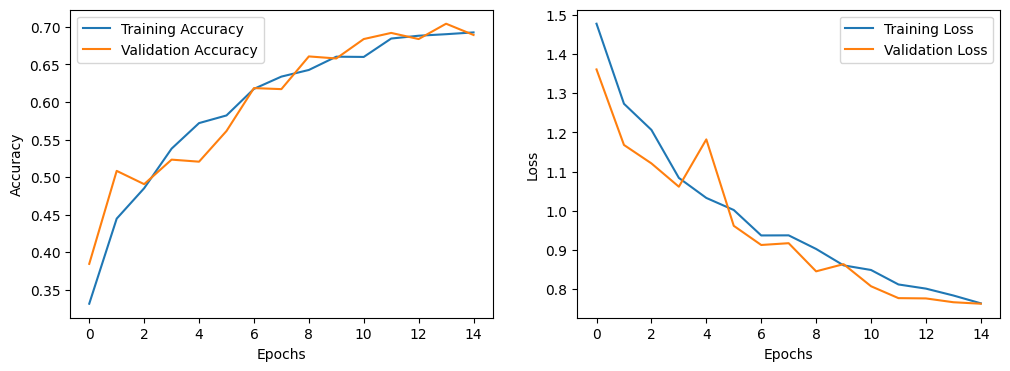

In [10]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
# Evaluate the model on the validation set
evaluation = model.evaluate(val_ds)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

23/23 [==============================] - 1s 42ms/step - loss: 0.7633 - accuracy: 0.6894
Validation Loss: 0.7632541656494141
Validation Accuracy: 0.6893733143806458
